In [1]:
# Dependencies
import numpy as np
from PIL import Image
import open3d as o3d
import json
import os
from tqdm import tqdm
import time
import pandas as pd

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams

import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from utils.misc import *
from collections import defaultdict

%matplotlib inline

INFO - 2022-01-18 21:13:12,192 - utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-01-18 21:13:12,193 - utils - NumExpr defaulting to 8 threads.


In [2]:
#establishing root data and folder for nuscenes
nuscenes_root = "/users/CeliaSagastume/Desktop/Lidar-Net/data/sets/nuscenes"
nusc = NuScenes(version='v1.0-mini', dataroot=nuscenes_root, verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.511 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
# Load the information from .txt file in JSON format
sample_path = os.getcwd() + '/dataset/samples/sample_0d7263a5b8264cad996582d6219ef1f2_file.txt'

# This is a Dictionary of lists of dictionaries
data_json = load_file(sample_path)

In [4]:
#Visualize point cloud data 

#Create instance metadata
annotation_metadata = data_json['instance'][0]

# point cloud
pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])

# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# # visualizing the 3D point cloud
# o3d.visualization.draw_geometries([pcd])

In [5]:
#Retrieve the image associated with the annotation

# Sample data from cam Sensor
cam_data = nusc.get('sample_data', annotation_metadata['camera_token'])
cam_data


{'token': 'd4e3bf742f05471b8afe69a4292b9f8d',
 'sample_token': '0d7263a5b8264cad996582d6219ef1f2',
 'ego_pose_token': 'd4e3bf742f05471b8afe69a4292b9f8d',
 'calibrated_sensor_token': '1c0a27b9bde24e3297029ded26e5c85c',
 'timestamp': 1535385101937558,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_BACK/n008-2018-08-27-11-48-51-0400__CAM_BACK__1535385101937558.jpg',
 'prev': '0b38ffeec2a141e2b775fb18b25a9ba5',
 'next': 'a548ccf1913041a0b06034e0fffbf898',
 'sensor_modality': 'camera',
 'channel': 'CAM_BACK'}

(-0.5, 1599.5, 899.5, -0.5)

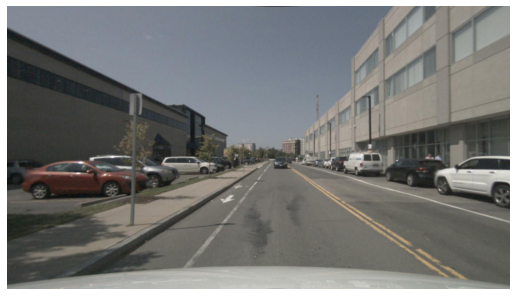

In [6]:
#Visualize image 

# Open image of the interest camera
im = Image.open(osp.join(nusc.dataroot, cam_data['filename']))

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.axis('off')

(-0.5, 1599.5, 899.5, -0.5)

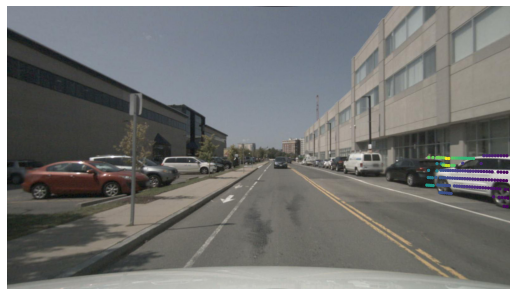

In [7]:
#plot the point cloud onto the image

# point cloud
pointcloud_cam = load_pcl_txt(annotation_metadata['img_pc_path'], annotation_metadata['img_pcl_shape'])

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.scatter(pointcloud_cam[0, :], pointcloud_cam[1, :], c = pointcloud_cam[3, :], s = 5)
plt.axis('off')

In [8]:
#Segment instance using DBScan
from sklearn.cluster import DBSCAN

# Using the DBScan object using Manhattan distance 'cityblock' 'euclidean' pointcloud_lidar.T
clustering = DBSCAN(eps = 1.5, min_samples = 20, metric = 'euclidean').fit(pointcloud_lidar.T)
# Clusters
dbscan_clusters = clustering.labels_ 
print('The unique clusters label are: {}'.format(np.unique(dbscan_clusters)))

The unique clusters label are: [-1  0  1]


In [9]:
#Find the cluster with the biggest amount of points within it

# Number of unique clusters and Delete -1 (noisy) class
# options: kmeans_clusters - aglomerative_clusters - meanshift_clusters - dbscan_clusters

pcd_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# Obtain the more repeated index different of -1
class_idx = np.bincount(dbscan_clusters[dbscan_clusters != -1]).argmax()
# Find indexes of interest cluster
indexes = np.where(dbscan_clusters == class_idx)[0]

# extract the point cloud of the current cluster
pcl_temp = pointcloud_lidar.T[indexes]
#  and save the point cloud in pcd
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# Saves the point cloud in .pcd file
o3d.io.write_point_cloud(pcd_path + 'pcd_segmentation_' + annotation_metadata['annotation_token'] + '.pcd', pcd)

# # visualizing the 3D point cloud
# o3d.visualization.draw_geometries([pcd])

True

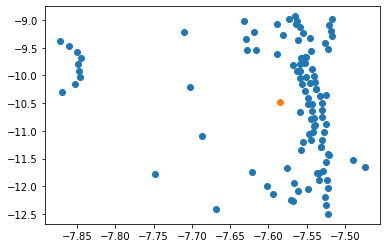

In [10]:
#test lines to extract principle line component

plt.scatter(pcl_temp[:, 0], pcl_temp[:, 1])
plt.scatter(pcd.get_center()[0], pcd.get_center()[1])
plt.show()

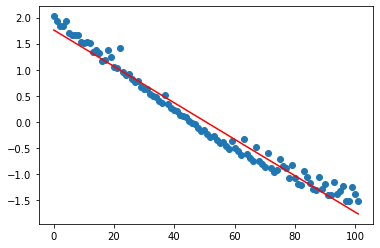

In [11]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
# keep the first two principal components of the data
pca = PCA(n_components = 1) 
# fit PCA model to beast cancer data 
pca.fit(pcl_temp) 


# transform data onto the first two principal components 
X_pca_train = pca.transform(pcl_temp) 
vals = np.arange(X_pca_train[:, 0].shape[0])
plt.scatter(vals, X_pca_train[:, 0])

vals = vals.reshape(-1,1)

reg = LinearRegression().fit(vals, X_pca_train)
new_vals = reg.predict(vals)
plt.plot(vals, new_vals, c = 'r')
plt.show()

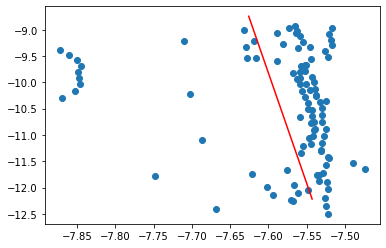

In [12]:
vals_transformed = pca.inverse_transform(new_vals)
plt.scatter(pcl_temp[:, 0], pcl_temp[:, 1])
plt.plot(vals_transformed[:, 0], vals_transformed[:, 1], c = 'r')
plt.show()

In [13]:
#Segment all point clouds in the dataset

# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to save point clouds in .csv
csv_path =  os.getcwd() + '/dataset/maybe/'

# List to store avg proccessing time
proc_times = []

#Dictionary to store point clouds 
pc_dict = defaultdict( lambda: defaultdict(list))

#Dictionary to store categories
cat_dict = defaultdict(list)

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):   
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for index in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][index]
            
            #Retrieve instance token 
            category_name = data_json['instance'][index]['category']
            
            #Retrieve annotation token
            annotation = annotation_metadata['annotation_token']

            # point cloud
            pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])
            
            
            # Start counting
            start = time.time()
            
            clustering = DBSCAN(eps = 1.75, min_samples = 20).fit(pointcloud_lidar.T)
            # Clusters
            dbscan_clusters = clustering.labels_
                
            # Obtain the more repeated index different of -1
            class_idx = np.bincount(dbscan_clusters[dbscan_clusters != -1]).argmax()
            # Find indexes of interest cluster
            indexes = np.where(dbscan_clusters == class_idx)[0]
            
            # extract the bigger cluster
            pcl_temp = pointcloud_lidar.T[indexes]
            
            # Finish the time counter
            end = time.time()
            proc_times.append(end - start)

            Velopoints = np.asarray(pcl_temp, np.float32)

               #add point cloud to dictionary 
            pc_dict[annotation]['pointcloud'].append(Velopoints.tolist())

            
            #add category label to category dictionary
            pc_dict[annotation]['category'].append(category_name)
            
        #convert dictionary to json file
        with open('pc_data.txt', 'w') as fp:
            json.dump(pc_dict, fp,  indent=4)


            
print('The avg proccessing time is: {}'.format(sum(proc_times) / len(proc_times)))
print('The minimum proccessing time was: {}'.format(min(proc_times)))
print('The maximum proccessing time was: {}'.format(max(proc_times)))

Sample files: 100%|███████████████████████████| 404/404 [10:30<00:00,  1.56s/it]

The avg proccessing time is: 0.0032227774271464363
The minimum proccessing time was: 0.0006470680236816406
The maximum proccessing time was: 0.03311014175415039


In [ ]:
# Instance Segmentation code from "High-level camera-LiDAR fusion for 3D object detection with machine learning"

@misc{salazargomez2021highlevel,
      title={High-level camera-LiDAR fusion for 3D object detection with machine learning}, 
      author={Gustavo A. Salazar-Gomez and Miguel A. Saavedra-Ruiz and Victor A. Romero-Cano},
      year={2021},
      eprint={2105.11060},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}